# Autoencoders 

Autoencoders are neural networks that learn low-dimensional latent representations from which the original data can be reconstructed as well as possible.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

data_with_labels = pd.read_csv("../data/tomato_with_targets.txt", index_col=0)
labels = ['species','position','tissue','root']
data_original = data_with_labels.drop(columns = labels, axis = 1).to_numpy()
# trainig_data_original = data_with_labels
trainig_data_original = data_with_labels.drop(data_with_labels[(data_with_labels["species"]=="M82") & (data_with_labels["position"]=="Sh")].index)
trainig_data_original = trainig_data_original.drop(columns = labels, axis = 1).to_numpy()
scaler = StandardScaler().set_output(transform="default")
training_data = scaler.fit_transform(trainig_data_original)
data = scaler.transform(data_original)

In [2]:
# For Colab
import os
os.environ["KERAS_BACKEND"] = "torch"

In [3]:
from keras.layers import Input, Dense, Lambda
from keras.models import Model
import keras

In [4]:
# for debugging
keras.config.disable_traceback_filtering()

We will apply an autoencoder approach to reduce the dimensionality of the tomato gene expression dataset. For computational efficiency, we will use here only the first 500 genes, so the following call reduces 500-dimensional profiles to two-dimensional profiles.

Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 707ms/step - loss: 0.8958
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.8938
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.8929
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.8919
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.8901
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.8873
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.8834
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.8780
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.8709
Epoch 10/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.8616
Epoch 11/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.8499
Epoch 12/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.8357
Epoch 13/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.8191
Epoch 14/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.8008
Epoch 15/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.7824
Epoch 16/200
1/1 ━

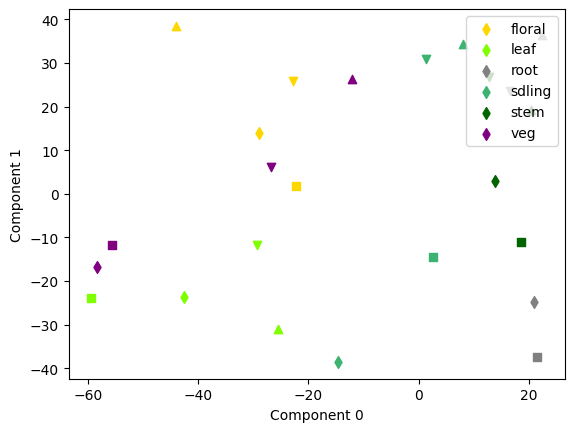

In [5]:
# Simple autoencoder without regularization
tissue_dict = {'floral': 'gold', 'leaf': 'chartreuse', 'root': 'gray', 'sdling': 'mediumseagreen', 'stem': 'darkgreen', 'veg': 'purple'}
species_condition_dict = {'penn.Sun': 's', 'penn.Sh': 'd', 'M82.Sun': '^', 'M82.Sh': 'v'}
def plot_components(data_transformed, j=0, k=1, tissuelegend=True, legendloc="upper right"):
    for i in range(0,data_transformed.shape[0]):
        plt.scatter(data_transformed[i,j], data_transformed[i,k], marker=species_condition_dict['.'.join([data_with_labels.iloc[i]['species'], data_with_labels.iloc[i]['position']])], c=tissue_dict[data_with_labels.iloc[i]['tissue']])
    plt.xlabel("Component {}".format(j)) 
    plt.ylabel("Component {}".format(k))
    if tissuelegend:
        plt.legend(tissue_dict, loc=legendloc)
    else:
        def make_markers(ind):
            return(plt.Line2D([], [], color='black', marker=list(species_condition_dict.values())[ind], linestyle='None'))
        plt.legend([make_markers(l) for l in range(0,len(species_condition_dict.values()))], species_condition_dict.keys(), loc=legendloc)
    plt.show()


def autoencoder(X, X_train, n_components=2):  

    layer_sizes = [128,64,32,16]
    #encoder
    inputs = Input(shape=(X.shape[1],), name='encoder_input')
    x = inputs
    for size in layer_sizes:
        x = Dense(size, activation='relu', kernel_initializer='glorot_normal')(x)

    z = Dense(n_components, kernel_initializer='glorot_normal', name='latent_mean')(x)
    encoder = Model(inputs, z, name='encoder')

    #decoder
    latent_inputs = Input(shape=(n_components,), name='decoder_input_sampling')
    x = latent_inputs
    for size in layer_sizes[::-1]:
        x = Dense(size, activation='relu', kernel_initializer='glorot_normal')(x)
    outputs = Dense(X.shape[1], activation=None, kernel_initializer='glorot_normal', name='decoder_output')(x)
    decoder = Model(latent_inputs, outputs, name='decoder')
        
    
    
    vae = Model(inputs, decoder(encoder(inputs)), name='vae')

    vae.compile(optimizer=keras.optimizers.Adam(), loss=keras.losses.MeanSquaredError(), run_eagerly=False) 
    vae.fit(x=X_train,y=X_train, epochs=200, verbose=1, batch_size=24)
    
    Y_VAE = encoder.predict(X)
    plot_components(Y_VAE)

keras.utils.set_random_seed(30)

autoencoder(data[:,range(500)], training_data[:,range(500)])


Next, we will try a variational autoencoder. This is an autoencoder that uses regularization during training to ensure that the latent space has certain properties. For that purpose, the loss function is composed of a reconstruction term (for the final layer) and a regularization term (for the latent layer).

In [6]:
# Variational autoencoder
class VAE(Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")

    def train_step(self, x):
        
        self.zero_grad()
        
        z_mean, z_log_var, z = self.encoder(x)
        x_decoded_mean = self.decoder(z)
   
        reconstruction_loss = keras.ops.mean(keras.ops.square(x-x_decoded_mean))
        
        kl_loss = - 0.5 * (1 + z_log_var - keras.ops.square(z_mean) - keras.ops.exp(z_log_var))
        
        kl_loss = keras.ops.mean(keras.ops.sum(kl_loss, axis=1))
        
        total_loss = reconstruction_loss
        
        total_loss.backward()

        trainable_weights = [v for v in self.trainable_weights]
        gradients = [v.value.grad for v in trainable_weights]
        self.optimizer.apply(gradients, trainable_weights)
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result()
        }
    
    def call(self, inputs, *args, **kwargs):
        return self.decoder(self.encoder(inputs)[2])
    
    @property
    def metrics(self):
        return [self.total_loss_tracker, self.reconstruction_loss_tracker]

def variational_autoencoder(X, X_train, n_components=2):  
    keras.utils.set_random_seed(42) 
    seed_generator = keras.random.SeedGenerator(42)
        
    def sampling(args):
        z_mean, z_log_var = args
        epsilon = keras.random.normal(shape=z_mean.size(), seed=seed_generator)
        return z_mean + keras.ops.exp(z_log_var) * epsilon

    layer_sizes = [128,64,32,16]
    
    #encoder
    inputs = Input(shape=(X.shape[1],), name='encoder_input')
    x = inputs
    for size in layer_sizes:
        x = Dense(size, activation='relu', kernel_initializer='glorot_normal')(x)

    z_mean = Dense(n_components, kernel_initializer='glorot_normal', name='latent_mean')(x)
    z_log_var = Dense(n_components, kernel_initializer='glorot_normal', name='latent_sigma')(x)

    z = Lambda(sampling, output_shape=(n_components,))([z_mean, z_log_var])
    encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')

    #decoder
    latent_inputs = Input(shape=(n_components,), name='decoder_input_sampling')
    x = latent_inputs
    for size in layer_sizes[::-1]:
        x = Dense(size, activation='relu', kernel_initializer='glorot_normal')(x)
    outputs = Dense(X.shape[1], activation=None, kernel_initializer='glorot_normal', name='decoder_output')(x)
    
    decoder = Model(latent_inputs, outputs, name='decoder')
        
    vae = VAE(encoder, decoder)
    vae.compile(optimizer=keras.optimizers.Adam())
    vae.fit(x=X_train, epochs=200, verbose=1, batch_size=24)
    
    z_mean, z_log_var, z = encoder.predict(X)
    print(z_mean)
    print(np.exp(z_log_var))
    
    plot_components(z, j=0, k=1)


Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - loss: 0.8951 - reconstruction_loss: 0.8951
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.8960 - reconstruction_loss: 0.8960
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.8943 - reconstruction_loss: 0.8943
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.8937 - reconstruction_loss: 0.8937
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.8936 - reconstruction_loss: 0.8936
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.8933 - reconstruction_loss: 0.8933
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.8917 - reconstruction_loss: 0.8917
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.8879 - reconstruction_loss: 0.8879
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.8830 - reconstruction_loss: 0.8830
Epoch 10/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.8789 - reconstruction_loss: 0.8789
Epoch 11/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/st

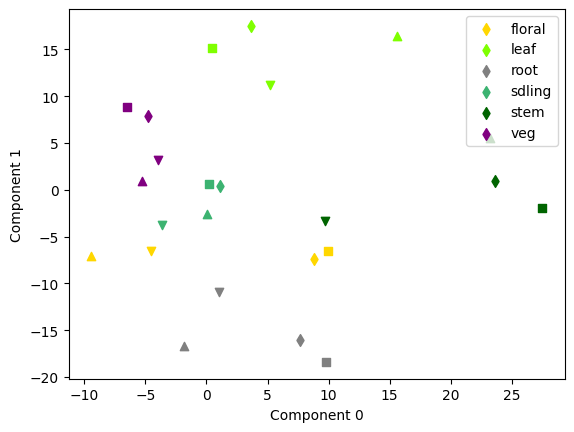

In [7]:

keras.utils.set_random_seed(42)
variational_autoencoder(data[:,range(500)], training_data[:,range(500)], n_components=2) 

### Task:
1. What is the rationale behind using regularization? What can happen without regularization?
2. What is a potential drawback of regularization? What can happen if regularization is too strong? You can play with the weight of the regularization term.